# [0] Fundaments of Machine Learning Final Project

In [2]:
import numpy as np
import random
random.seed(19830732)
my_seed = int(np.round(random.random()*100))
print(my_seed)

86


# [1] Import Packages

In [3]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 29.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095423 sha256=8198555e30555c7335fce8603e175557387e69c2fefc61c04723867a757cff47
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [4]:
pip install mf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.5/349.5 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.0 MB/s eta 0:00:00
  Created wheel for mf: filename=mf-0.1.38-py3-none-any.whl size=15347 sha256=0a952b4d759a4af24d7424d949c7559fd7058f3800c69574d3a94781df0a8318
  Stored in directory: /root

In [5]:
import pandas as pd
import numpy as np
import math
import re
import sklearn
import scipy
import scipy.stats
import scipy.io
import scipy.sparse as sp
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from cvxpy import *
from numpy import matrix
import re
import mf
from scipy.sparse import csr_matrix

# [2] Data Preparation

## Parse Data


### data.txt

In [6]:
import pandas as pd

def parse_data(file_path):
    data = []
    current_movie_id = None
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.endswith(':'):
                current_movie_id = int(line[:-1])
            else:
                try:
                    user_id, rating, date = line.split(',')
                    user_id, rating = int(user_id), int(rating)
                    data.append([current_movie_id, user_id, rating, date])
                except ValueError:
                    print(f"Line could not be parsed: {line}")
    return pd.DataFrame(data, columns=['movie_id', 'user_id', 'rating', 'date'])

file_path = "data.txt"
df = parse_data(file_path)

# Convert data types and preprocess date column
df['rating'] = df['rating'].astype(float)

df['date'] = df['date'].astype(str)
df['date'] = df['date'].map( lambda s : (s[:4])+(s[5:7])+(s[8:]))
df['date'] = df['date'].astype(float)

# Print dataset information and examples
print(f'Dataset shape: {df.shape}')
print(f'Dataset examples:\n{df.iloc[::100, :]}')


Dataset shape: (27010225, 4)
Dataset examples:
          movie_id  user_id  rating        date
0                1  1488844     3.0  20050906.0
100              1  1155747     3.0  20050703.0
200              1  1141189     4.0  20041215.0
300              1  2256485     1.0  20040819.0
400              1  2322840     3.0  20050712.0
...            ...      ...     ...         ...
27009800      5000   608234     3.0  20041108.0
27009900      5000  1294431     5.0  20030730.0
27010000      5000   752642     1.0  20010217.0
27010100      5000  1932594     3.0  20040502.0
27010200      5000   352620     2.0  20040729.0

[270103 rows x 4 columns]


In [7]:
print("Final Datatypes of the Dataset")
print(df.dtypes)

Final Datatypes of the Dataset
movie_id      int64
user_id       int64
rating      float64
date        float64
dtype: object


### movie_titles.csv

In [8]:
def load_movie_titles(file_path):
    column_names = ['release_date', 'title', 'unnamed_1', 'unnamed_2']
    movie_titles = pd.read_csv(file_path, header=None, names=column_names)
    # movie_titles['release_date'] = pd.to_datetime(movie_titles['release_date'])
    movie_titles = movie_titles.drop(columns=['unnamed_1', 'unnamed_2'])
    
    # Add a new column 'movie_id'
    movie_titles['movie_id'] = range(1, len(movie_titles)+1)
    
    return movie_titles

movie_titles_file = 'movieTitles.csv'
movie_titles_df = load_movie_titles(movie_titles_file)
movie_titles_df.head()

,release_date,title,movie_id
1,2003.0,Dinosaur Planet,1
2,2004.0,Isle of Man TT 2004 Review,2
3,1997.0,Character,3
4,1994.0,Paula Abdul's Get Up & Dance,4
5,2004.0,The Rise and Fall of ECW,5


In [9]:
# Check for missing user IDs
missing_user_ids = set(range(1, df['user_id'].max() + 1)) - set(df['user_id'].unique())
num_missing_users = len(missing_user_ids)
print(f'Number of rows with missing user IDs: {num_missing_users}')

# Check for missing movie IDs
missing_movie_ids = set(range(1, df['movie_id'].max() + 1)) - set(df['movie_id'].unique())
num_missing_movies = len(missing_movie_ids)
print(f'Number of rows with missing movie IDs: {num_missing_movies}')

Number of rows with missing user IDs: 2176887
Number of rows with missing movie IDs: 0


# [3] Data Pre-Processing

## Creating Sparse Matrix with User ID and Movie ID

In [10]:
pip install tables

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import pandas as pd
from scipy.sparse import csr_matrix

# Filter out zero ratings
df_filtered = df[df['rating'] != 0]

# Create a sparse matrix
row = df_filtered['user_id'].astype(int)
col = df_filtered['movie_id'].astype(int)
data = df_filtered['rating']

sparse_matrix = csr_matrix((data, (row, col)))

print(f'Sparse data matrix created with shape: {sparse_matrix.shape}')

Sparse data matrix created with shape: (2649430, 5001)


In [12]:
def print_first_n_entries(sparse_matrix, n=5):
    row, col = sparse_matrix.nonzero()
    for i in range(n):
        user_id = row[i] + 1  # Add 1 to match the original user ID
        movie_id = col[i] + 1  # Add 1 to match the original movie ID
        rating = sparse_matrix[row[i], col[i]]
        print(f'User ID: {user_id}, Movie ID: {movie_id}, Rating: {rating}')

# Call the function to print the first 5 entries
print_first_n_entries(sparse_matrix, 10)

User ID: 7, Movie ID: 31, Rating: 3.0
User ID: 7, Movie ID: 158, Rating: 3.0
User ID: 7, Movie ID: 174, Rating: 4.0
User ID: 7, Movie ID: 176, Rating: 5.0
User ID: 7, Movie ID: 192, Rating: 2.0
User ID: 7, Movie ID: 198, Rating: 3.0
User ID: 7, Movie ID: 242, Rating: 3.0
User ID: 7, Movie ID: 296, Rating: 4.0
User ID: 7, Movie ID: 300, Rating: 3.0
User ID: 7, Movie ID: 330, Rating: 4.0


In [13]:
unique_users = len(set(sparse_matrix.nonzero()[0]))
print(f"Number of unique users: {unique_users}")

Number of unique users: 472542


In [14]:
unique_users = len(set(sparse_matrix.nonzero()[1]))
print(f"Number of unique movies: {unique_users}")

Number of unique movies: 5000


# [4] Data Exploration

## Distribution of Ratings Given by Users

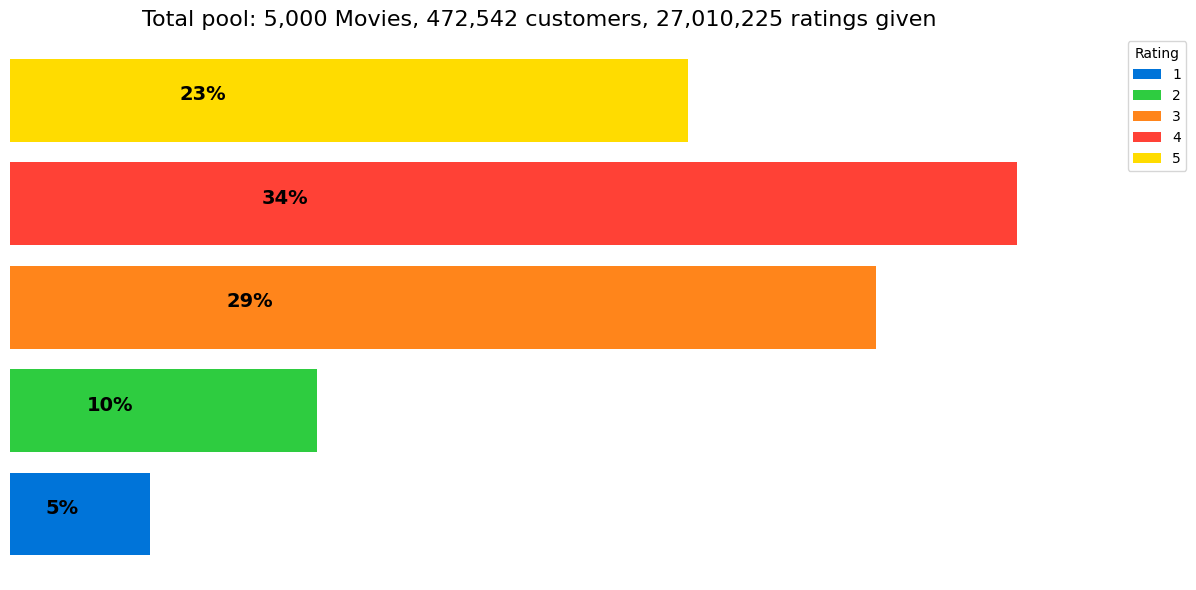

In [15]:
import matplotlib.pyplot as plt

# group ratings and count number of occurrences
ratings_grouped = df['rating'].value_counts()

# get number of movies, customers, and ratings
num_movies = df['movie_id'].nunique()
num_customers = df['user_id'].nunique()
num_ratings = df.shape[0]

# define colors for each rating
colors = ['#0074D9', '#2ECC40', '#FF851B', '#FF4136', '#FFDC00']

# map ratings to colors
ratings_colors = {1: colors[0], 2: colors[1], 3: colors[2], 4: colors[3], 5: colors[4]}

# create horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(ratings_grouped.index, ratings_grouped.values, color=[ratings_colors[r] for r in ratings_grouped.index])
plt.title(f'Total pool: {num_movies:,} Movies, {num_customers:,} customers, {num_ratings:,} ratings given', fontsize=16)
plt.axis('off')

# add text labels to bars
for i, rating in enumerate(ratings_grouped.index):
    percentage = ratings_grouped.values[i] / num_ratings * 100
    ax.text(ratings_grouped.values[i]/4, rating, f'{percentage:.0f}%', color='black', weight='bold', fontsize=14)

# add legend for ratings colors
legend_handles = []
for r in range(1, 6):
    legend_handles.append(plt.Rectangle((0,0), 1, 1, fc=ratings_colors[r]))
ax.legend(legend_handles, ['1', '2', '3', '4', '5'], bbox_to_anchor=(1.05, 1), loc='upper left', title='Rating')

plt.tight_layout()
plt.show()


## Mean Ratings for Each Movie

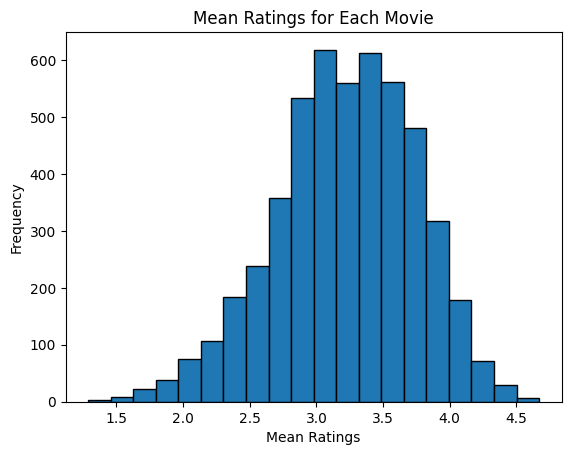

In [16]:
# Calculate mean ratings for each movie
mean_ratings = df.groupby('movie_id')['rating'].mean()

# Create histogram of mean ratings
plt.hist(mean_ratings, bins=20, edgecolor='black')
plt.xlabel('Mean Ratings')
plt.ylabel('Frequency')
plt.title('Mean Ratings for Each Movie')
plt.show()

## Mode Ratings from Each User

<ipython-input-17-cb0c434590a6>:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_ratings = df.groupby('user_id')['rating'].agg(lambda x: stats.mode(x)[0][0])


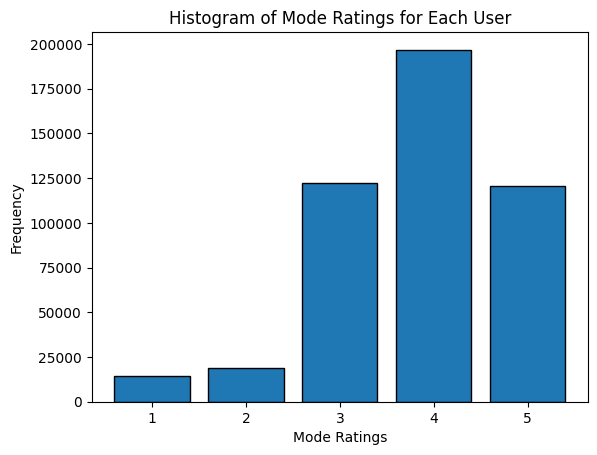

In [17]:
from scipy import stats

# Calculate mode ratings for each user
mode_ratings = df.groupby('user_id')['rating'].agg(lambda x: stats.mode(x)[0][0])

# Create histogram of mode ratings
plt.hist(mode_ratings, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black', rwidth=0.8)
plt.xlabel('Mode Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of Mode Ratings for Each User')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

# [5] Base Model: Mean Rating

## [A] Model Training

In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Set a random seed for reproducibility
random_seed = 42

# Select one random rating per movie for the test set
test_df = df.groupby('movie_id').apply(lambda x: x.sample(n=1, random_state=random_seed)).reset_index(drop=True)
train_df = df.drop(test_df.index)

# Calculate global mean
global_mean = train_df['rating'].mean()

# Make predictions
test_df['prediction'] = global_mean

# Calculate RMSE
rmse_base = np.sqrt(mean_squared_error(test_df['rating'], test_df['prediction']))
print("RMSE on Test: ", rmse_base)

RMSE on Test:  1.2766639435883955


Confirm Train-Test Split is as Desired

In [19]:
print("Size of train_df: ", train_df.shape)
print("Size of test_df: ", test_df.shape)

Size of train_df:  (27005225, 4)
Size of test_df:  (5000, 5)


In [20]:
# Print column names of train set
print("Train set column names:", train_df.columns)

# Print column names of test set
print("Test set column names:", test_df.columns)

Train set column names: Index(['movie_id', 'user_id', 'rating', 'date'], dtype='object')
Test set column names: Index(['movie_id', 'user_id', 'rating', 'date', 'prediction'], dtype='object')


# [6] Baseline Models 

## Model 1: User's Mean Ratings

In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Set a random seed for reproducibility
random_seed = 42

# Select one random rating per movie for the test set
test_df = df.groupby('movie_id').sample(n=1, random_state=random_seed)
train_df = df.drop(test_df.index)

# Calculate user mean ratings
user_mean_ratings = train_df.groupby('user_id')['rating'].mean()
overall_mean_rating = train_df['rating'].mean()

# Make predictions
test_df['prediction'] = test_df['user_id'].apply(lambda user_id: user_mean_ratings.get(user_id, overall_mean_rating))

# Calculate RMSE
rmse_user_mean = np.sqrt(mean_squared_error(test_df['rating'], test_df['prediction']))
print("RMSE on Test (User Mean): ", rmse_user_mean)

RMSE on Test (User Mean):  1.1228696375413207


## Model 2: User's Median Ratings

In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Set a random seed for reproducibility
random_seed = 42

# Select one random rating per movie for the test set
test_df = df.groupby('movie_id').sample(n=1, random_state=random_seed)
train_df = df.drop(test_df.index)

# Calculate user median ratings
user_median_ratings = train_df.groupby('user_id')['rating'].median()
overall_median_rating = train_df['rating'].median()

# Make predictions
test_df['prediction'] = test_df['user_id'].apply(lambda user_id: user_median_ratings.get(user_id, overall_median_rating))

# Calculate RMSE
rmse_user_median = np.sqrt(mean_squared_error(test_df['rating'], test_df['prediction']))
print("RMSE on Test (User Median): ", rmse_user_median)

RMSE on Test (User Median):  1.2064410470470572


## Model 3: Movie's Mean Ratings

In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Set a random seed for reproducibility
random_seed = 42

# Select one random rating per movie for the test set
test_df = df.groupby('movie_id').sample(n=1, random_state=random_seed)
train_df = df.drop(test_df.index)

# Calculate movie mean ratings
movie_mean_ratings = train_df.groupby('movie_id')['rating'].mean()

# Make predictions
test_df['prediction'] = test_df['movie_id'].apply(lambda movie_id: movie_mean_ratings[movie_id])

# Calculate RMSE
rmse_movie_mean = np.sqrt(mean_squared_error(test_df['rating'], test_df['prediction']))
print("RMSE on Test (Movie Mean): ", rmse_movie_mean)

RMSE on Test (Movie Mean):  1.1160308239831598


## Model 4: Movie's Median Rating

In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Set a random seed for reproducibility
random_seed = 42

# Select one random rating per movie for the test set
test_df = df.groupby('movie_id').sample(n=1, random_state=random_seed)
train_df = df.drop(test_df.index)

# Calculate movie median ratings
movie_median_ratings = train_df.groupby('movie_id')['rating'].median()

# Make predictions
test_df['prediction'] = test_df['movie_id'].apply(lambda movie_id: movie_median_ratings[movie_id])

# Calculate RMSE
rmse_movie_median = np.sqrt(mean_squared_error(test_df['rating'], test_df['prediction']))
print("RMSE on Test (Movie Median): ", rmse_movie_median)

RMSE on Test (Movie Median):  1.1578860047517632


## Comparison of the Models

### Bar Plot of RMSE value

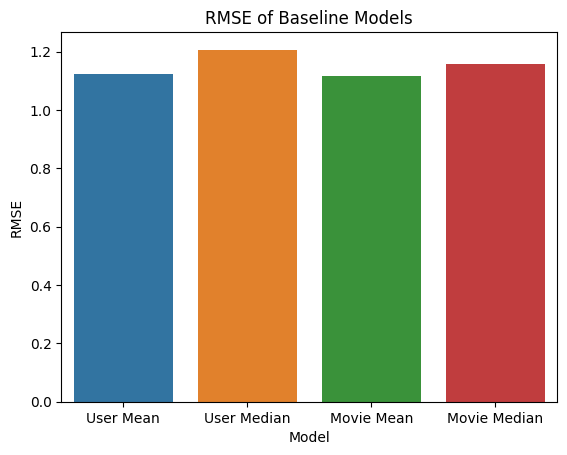

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot of RMSE values
sns.barplot(x=['User Mean', 'User Median', 'Movie Mean', 'Movie Median'], y=[rmse_user_mean, rmse_user_median, rmse_movie_mean, rmse_movie_median])
plt.title('RMSE of Baseline Models')
plt.xlabel('Model')
plt.ylabel('RMSE')

# Change x-axis label size
plt.xticks(fontsize=10)

# Show the plot
plt.show()

#### RMSE of Basic Models

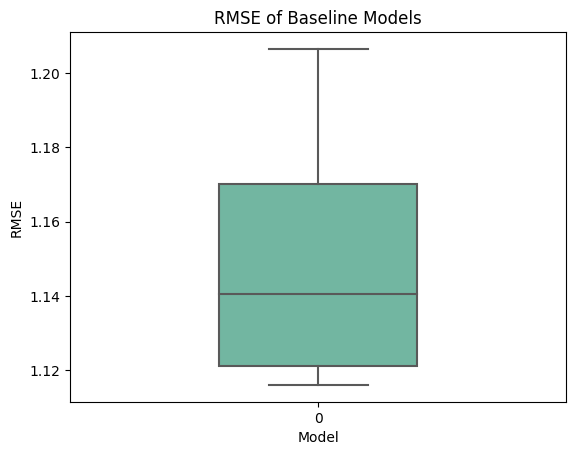

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a box plot of RMSE values
sns.boxplot(data=[rmse_user_mean, rmse_user_median, rmse_movie_mean, rmse_movie_median], 
            width=0.4,
            palette='Set2')
plt.title('RMSE of Baseline Models')
plt.xlabel('Model')
plt.ylabel('RMSE')

# Show the plot
plt.show()

# [7] Main Models 

## Model 1: Matrix Factorization

### Matrix Factorization

In [27]:
import numpy as np

class MatrixFactorization():
    def __init__(self, ratings_matrix, num_latent_dims, learning_rate, regularization_parameter, num_iterations):
        """
        Perform matrix factorization to predict empty entries in a matrix.

        Arguments
        - ratings_matrix (ndarray)      : user-item rating matrix
        - num_latent_dims (int)         : number of latent dimensions
        - learning_rate (float)         : learning rate
        - regularization_parameter (float): regularization parameter
        - num_iterations (int)          : number of iterations to perform stochastic gradient descent
        """

        self.R = ratings_matrix
        self.num_users, self.num_items = ratings_matrix.shape
        self.K = num_latent_dims
        self.alpha = learning_rate
        self.beta = regularization_parameter
        self.iterations = num_iterations

    def train(self):
        # Initialize user and item latent feature matrices
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [(i, j, self.R[i, j]) for i in range(self.num_users) for j in range(self.num_items) if self.R[i, j] > 0]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic gradient descent
        """
        for i, j, r in self.samples:
            # Compute prediction and error
            prediction = self.get_rating(i, j)
            error = r - prediction

            # Update biases
            self.b_u[i] += self.alpha * (error - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (error - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (error * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (error * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Compute the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)


### Training Matrix Factorization Model

In [28]:
import numpy as np
from sklearn.metrics import mean_squared_error
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV

# Reduce the size of the dataset by randomly selecting a smaller subset
subset_df = df.sample(n=10000, random_state=42)

# Convert the sparse matrix to Surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(subset_df[['user_id', 'movie_id', 'rating']], reader)

# Define the range of latent attributes to search
latent_attribute_range = np.arange(5, 51, 5)  # Search from 5 to 50 latent attributes, in increments of 5

# Set the hyperparameters for grid search
param_grid = {
    'n_factors': latent_attribute_range,
    'n_epochs': [20],  # Number of training epochs
    'lr_all': [0.005],  # Learning rate for all parameters
    'reg_all': [0.02],  # Regularization term for all parameters
}

# Create and fit the GridSearchCV object
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
grid_search.fit(data)

# Get the best parameters and the corresponding RMSE
best_params = grid_search.best_params['rmse']
best_rmse = grid_search.best_score['rmse']

print(f"Best number of latent attributes: {best_params['n_factors']}")
print(f"Best RMSE: {best_rmse}")

Best number of latent attributes: 15
Best RMSE: 1.0539844590758503


In [29]:
# Train a matrix factorization model on the full dataset
mf = SVD(n_factors=best_params['n_factors'], n_epochs=20, lr_all=0.005, reg_all=0.02)
mf.fit(data.build_full_trainset())

### Creating Test Set and Evaluating Model

In [30]:
import random
import numpy as np
from scipy.sparse import find, csr_matrix
from sklearn.metrics import mean_squared_error

# Find the non-zero ratings in the sparse matrix
rows, cols, ratings = find(sparse_matrix)

# Initialize the train and test matrices
train_data = []
test_data = []
train_indices = []
test_indices = []

# Split the data by movie id
unique_movies = np.unique(cols)
for movie_id in unique_movies:
    # Get the indices where the movie is rated
    movie_indices = np.where(cols == movie_id)[0]

    # Randomly choose one rating to put in the test set
    test_idx = random.choice(movie_indices)
    train_indices_movie = np.delete(movie_indices, np.where(movie_indices == test_idx))

    # Add the ratings to the train and test data
    train_data.extend(ratings[train_indices_movie])
    test_data.append(ratings[test_idx])
    train_indices.extend([(rows[i], movie_id) for i in train_indices_movie])
    test_indices.append((rows[test_idx], movie_id))

# Convert the train and test data back to sparse matrices
train_sparse_matrix = csr_matrix((train_data, zip(*train_indices)), shape=sparse_matrix.shape)
test_sparse_matrix = csr_matrix((test_data, zip(*test_indices)), shape=sparse_matrix.shape)

# Get the predicted ratings for the test set
testset = [(user_idx, movie_idx, rating) for (user_idx, movie_idx), rating in zip(test_indices, test_data)]
test_pred = mf.test(testset)

# Extract true labels
test_labels = np.array(test_data)

# Evaluate performance using RMSE
test_rmse = mean_squared_error(test_labels, [pred.est for pred in test_pred], squared=False)
print('RMSE on Test Set:', test_rmse)


RMSE on Test Set: 1.2512435335239207


In [31]:
import numpy as np
from scipy.sparse import find, coo_matrix

# Get the row indices, column indices, and ratings
rows, cols, ratings = find(sparse_matrix)

# Split the data by movie id
unique_movies = np.unique(cols)
train_data = []
test_data = []
train_indices = []
test_indices = []
for movie_id in unique_movies:
    # Get the indices where the movie is rated
    movie_indices = np.where(cols == movie_id)[0]

    # Randomly choose one rating to put in the test set
    test_idx = np.random.choice(movie_indices)
    train_indices_movie = np.delete(movie_indices, np.where(movie_indices == test_idx))

    # Add the ratings to the train and test data
    train_data.extend(ratings[train_indices_movie])
    test_data.append(ratings[test_idx])
    train_indices.extend([(rows[i], movie_id) for i in train_indices_movie])
    test_indices.append((rows[test_idx], movie_id))

# Create sparse matrices for train and test data
train_matrix = coo_matrix((train_data, zip(*train_indices)), shape=sparse_matrix.shape)
test_matrix = coo_matrix((test_data, zip(*test_indices)), shape=sparse_matrix.shape)

print('Train matrix:\n', train_matrix)
print('Test matrix:\n', test_matrix)

Train matrix:
   (915, 1)	5.0
  (2442, 1)	3.0
  (3321, 1)	3.0
  (4326, 1)	4.0
  (11589, 1)	3.0
  (13651, 1)	3.0
  (14756, 1)	4.0
  (14924, 1)	5.0
  (16272, 1)	4.0
  (21722, 1)	4.0
  (30245, 1)	5.0
  (30878, 1)	4.0
  (31913, 1)	4.0
  (34907, 1)	3.0
  (38052, 1)	3.0
  (42921, 1)	3.0
  (42930, 1)	3.0
  (45117, 1)	5.0
  (51334, 1)	4.0
  (54774, 1)	4.0
  (55016, 1)	3.0
  (57961, 1)	4.0
  (59052, 1)	2.0
  (60343, 1)	5.0
  (68033, 1)	4.0
  :	:
  (2550838, 5000)	4.0
  (2554058, 5000)	3.0
  (2554750, 5000)	5.0
  (2565081, 5000)	3.0
  (2583187, 5000)	4.0
  (2584676, 5000)	3.0
  (2587314, 5000)	3.0
  (2597077, 5000)	2.0
  (2597802, 5000)	1.0
  (2600558, 5000)	3.0
  (2602249, 5000)	3.0
  (2602874, 5000)	4.0
  (2606799, 5000)	5.0
  (2609870, 5000)	1.0
  (2615044, 5000)	4.0
  (2617430, 5000)	5.0
  (2630158, 5000)	5.0
  (2630797, 5000)	2.0
  (2631950, 5000)	1.0
  (2632990, 5000)	3.0
  (2635011, 5000)	5.0
  (2635943, 5000)	5.0
  (2640550, 5000)	4.0
  (2643775, 5000)	4.0
  (2648853, 5000)	3.0
Test matr

In [32]:
from sklearn.metrics import mean_squared_error

# Get the test labels
test_labels = np.array(test_data)

# Get the test predictions
test_predictions = [mf.predict(uid, iid).est for uid, iid in test_indices]

# Calculate RMSE
mf_test_rmse = mean_squared_error(test_labels, test_predictions, squared=False)
print('RMSE =', mf_test_rmse)

RMSE = 1.2724283407421781


## Model 2: Singular Value Decomposition

In [33]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Train-Test Split

In [34]:
import numpy as np

# Add a new column 'random_number' to the df with random numbers between 0 and 1
df['random_number'] = np.random.rand(len(df))

# Find the index of the minimum random_number for each movie_id group
idx = df.groupby('movie_id')['random_number'].idxmin()

# Create the test set using the minimum random_number index for each movie_id
test_df = df.loc[idx].reset_index(drop=True)

# Create the train set by excluding the test set indices from df
train_df = df.drop(idx).reset_index(drop=True)

# Drop the 'random_number' column from train and test DataFrames
train_df.drop('random_number', axis=1, inplace=True)
test_df.drop('random_number', axis=1, inplace=True)

# Check the train and test DataFrames
print("Train set:\n", train_df.head())
print("\nTest set:\n", test_df.head())

Train set:
    movie_id  user_id  rating        date
0         1  1488844     3.0  20050906.0
1         1   822109     5.0  20050513.0
2         1   885013     4.0  20051019.0
3         1    30878     4.0  20051226.0
4         1   823519     3.0  20040503.0

Test set:
    movie_id  user_id  rating        date
0         1  2451020     4.0  20040914.0
1         2  1507649     5.0  20050217.0
2         3     4783     4.0  20030425.0
3         4    98649     2.0  20041102.0
4         5   329475     5.0  20050129.0


### Data Pre-Processing

In [35]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['user_id']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['movie_id'])])
 
# Create a pipeline with the preprocessor
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the train set

X_train = preprocessing_pipeline.fit_transform(train_df.drop('rating', axis=1))
y_train = train_df['rating']

# Transform the test set
X_test = preprocessing_pipeline.transform(test_df.drop('rating', axis=1))
y_test = test_df['rating']


### Model Training

In [36]:
print("Number of dimensions in train_df: ", train_df.ndim)

Number of dimensions in train_df:  2


In [37]:
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import mean_squared_error

# Define total sample size
total_sample_size = 1000000

# Initialize a list to store samples from each unique film
film_samples = []

# Calculate total number of user ratings
total_user_ratings = train_df['rating'].count()

# For each unique film, calculate the proportion of total ratings and use it to determine the sample size for that film
for movie_id, group in train_df.groupby('movie_id'):
    film_proportion = len(group) / total_user_ratings
    film_sample_size = round(film_proportion * total_sample_size)

    # Take a sample of the calculated size from the film's ratings
    film_sample = group.sample(film_sample_size, random_state=my_seed)
    film_samples.append(film_sample)

# Combine all the samples into a single DataFrame
subset_df = pd.concat(film_samples)

# Convert the train set to a Surprise dataset
data_reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(subset_df[['user_id', 'movie_id', 'rating']], data_reader)

# Construct the complete training set (no splitting needed here)
complete_trainset = data.build_full_trainset()

# Define the range of latent features to search
latent_feature_range = np.arange(5, 51, 5)  # Search from 5 to 50 latent features, in increments of 5

# Set the hyperparameters for grid search
hyperparameters = {
    'n_factors': latent_feature_range,
    'n_epochs': [20],  # Number of training epochs
    'lr_all': [0.005],  # Learning rate for all parameters
    'reg_all': [0.02],  # Regularization term for all parameters
}

# Instantiate and fit the GridSearchCV object
grid_search_cv = GridSearchCV(SVD, hyperparameters, measures=['rmse'], cv=3, n_jobs=-1)
grid_search_cv.fit(data)

# Retrieve the best parameters and the corresponding RMSE
optimal_params = grid_search_cv.best_params['rmse']
optimal_rmse = grid_search_cv.best_score['rmse']

print(f"Optimal number of latent features: {optimal_params['n_factors']}")
print(f"Optimal RMSE: {optimal_rmse}")

# Train a model on the full training set using the best model parameters
optimal_model = SVD(n_factors=optimal_params['n_factors'], 
                    n_epochs=optimal_params['n_epochs'], 
                    lr_all=optimal_params['lr_all'], 
                    reg_all=optimal_params['reg_all'])
optimal_model.fit(complete_trainset)

# Predict ratings for the test set and calculate RMSE
actual_ratings = []
predicted_ratings = []
for index, row in test_df.iterrows():
    rating_prediction = optimal_model.predict(row['user_id'], row['movie_id'])
    actual_ratings.append(row['rating'])
    predicted_ratings.append(rating_prediction.est)

# Calculate the RMSE for the test set
svd_test_rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print(f"Test RMSE: {svd_test_rmse}")

Optimal number of latent features: 5
Optimal RMSE: 0.985778401743232
Test RMSE: 1.0579347324108443


### Model Optimization

In [38]:
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import mean_squared_error

# Define total sample size
total_sample_size = 1000000

# Initialize a list to store samples from each unique film
film_samples = []

# Calculate total number of user ratings
total_user_ratings = train_df['rating'].count()

# For each unique film, calculate the proportion of total ratings and use it to determine the sample size for that film
for movie_id, group in train_df.groupby('movie_id'):
    film_proportion = len(group) / total_user_ratings
    film_sample_size = round(film_proportion * total_sample_size)

    # Take a sample of the calculated size from the film's ratings
    film_sample = group.sample(film_sample_size, random_state=my_seed)
    film_samples.append(film_sample)

# Combine all the samples into a single DataFrame
subset_df = pd.concat(film_samples)

# Convert the train set to a Surprise dataset
data_reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(subset_df[['user_id', 'movie_id', 'rating']], data_reader)

# Construct the complete training set (no splitting needed here)
complete_trainset = data.build_full_trainset()

# Define the range of latent features to search
latent_feature_range = np.arange(5, 51, 5)  # Search from 5 to 50 latent features, in increments of 5

# Define a range of learning rates to search
learning_rate_range = [0.001, 0.005, 0.01, 0.05]

# Define a range of regularization terms to search
regularization_range = [0.01, 0.02, 0.05, 0.1]

# Update the hyperparameters for grid search
hyperparameters = {
    'n_factors': latent_feature_range,
    'n_epochs': [10, 20],  # Try with fewer and more training epochs
    'lr_all': learning_rate_range,
    'reg_all': regularization_range,
}

# Update the GridSearchCV object
grid_search_cv = GridSearchCV(SVD, hyperparameters, measures=['rmse'], cv=3, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search_cv.fit(data)

# Get the best parameters and the corresponding RMSE
optimal_params = grid_search_cv.best_params['rmse']
svd_optimal_rmse = grid_search_cv.best_score['rmse']

print(f"Optimal number of latent features: {optimal_params['n_factors']}")
print(f"Optimal learning rate: {optimal_params['lr_all']}")
print(f"Optimal regularization term: {optimal_params['reg_all']}")
print(f"Optimal RMSE: {svd_optimal_rmse}")


Optimal number of latent features: 5
Optimal learning rate: 0.005
Optimal regularization term: 0.05
Optimal RMSE: 0.9846562366962665


# [8] Other Models 
##### Note: Models failed due to not enough System RAM to run code.

## Model 1: Singular Value Decomposition (Version 2)
##### Based on architecture of model, would expect V2 to perform better than SVD done in main model.

In [ ]:
import pandas as pd
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
import random

# Set a random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

# Select one random rating per movie for the test set
test_df = df.groupby('movie_id').sample(n=1, random_state=random_seed)
train_df = df.drop(test_df.index)

# Create Surprise Dataset
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['user_id', 'movie_id', 'rating']], reader)

# Split the data into a trainset and a testset
trainset = data.build_full_trainset()

# Create testset
testset = [tuple(x) for x in test_df.to_numpy()]

# Train SVD model
svd = SVD(random_state=random_seed)
svd.fit(trainset)

# Make predictions
predictions = svd.test(testset)

# Calculate RMSE
rmse = accuracy.rmse(predictions)
print("RMSE on Test: ", rmse)

## Model 2: Cosine-Similarity


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Set a random seed for reproducibility
random_seed = 42

# Select one random rating per movie for the test set
test_df = df.groupby('movie_id').sample(n=1, random_state=random_seed)
train_df = df.drop(test_df.index)

# Calculate cosine similarity between users
user_similarity = cosine_similarity(sparse_matrix)
user_similarity = pd.DataFrame(user_similarity, index=sparse_matrix.index, columns=sparse_matrix.index)

# Make predictions
def predict(user_id, movie_id):
    if movie_id in sparse_matrix:
        user_ratings = sparse_matrix[movie_id]
        user_similarities = user_similarity[user_id]
        weighted_sum = np.dot(user_similarities.fillna(0), user_ratings.fillna(0))
        similarity_sum = np.sum(user_similarities[user_ratings.notna()])
        
        if similarity_sum != 0:
            return weighted_sum / similarity_sum
        else:
            return sparse_matrix.loc[user_id].mean()
    else:
        return sparse_matrix.loc[user_id].mean()

test_df['prediction'] = test_df.apply(lambda row: predict(row['user_id'], row['movie_id']), axis=1)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_df['rating'], test_df['prediction']))
print("RMSE on Test: ", rmse)

## Model 3: Light Factorization Machines (LightFM) 

Factorization Machines" (FM) model, which is a type of factorization model that is specifically designed for sparse and high-dimensional data. The FM model is similar to matrix factorization techniques, but it models the interactions between user and item features, rather than just the raw user-item ratings.

We implement the FM model using the "LightFM" library in Python. We use the "warp-kos" loss function, that is, a type of pairwise ranking loss that is suitable for implicit feedback data, like movie ratings. The model is trained for 10 epochs, and the number of threads is set to 4 to speed up the training.

In [ ]:
pip install LightFM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for LightFM: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=879128 sha256=5b5417dbf18c4b8340fcb4197ed1a82806d4c64bb0c214b5f0362b3743638941
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built LightFM


In [ ]:
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset
from sklearn.metrics import mean_squared_error

# Set a random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Select one random rating per item for the test set
df['random_number'] = np.random.rand(len(df))
df_sorted = df.sort_values(by='random_number')
test_df = df_sorted.groupby('movie_id').first().reset_index(drop=False)
train_df = df.drop(test_df.index)

# Create LightFM Dataset
dataset = Dataset()
dataset.fit(df['user_id'], df['movie_id'])  # Note: fit on the whole data

# Get mappings
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()

# Split the data into a trainset and a testset
test_item_ids = test_df['movie_id']
test_user_ids = test_df['user_id']
test_ratings = test_df['rating']
(interactions_matrix, weights_matrix) = dataset.build_interactions([(x['user_id'], x['movie_id'], x['rating']) for idx, x in train_df.iterrows()])

# Split the test set into individual ratings
testset = list(zip(test_user_ids, test_item_ids, test_ratings))

# Train FM model
fm = LightFM(loss='warp-kos', random_state=random_seed)
fm.fit(interactions_matrix, epochs=10, num_threads=4)  # Here we provide only the interactions matrix

# Make predictions
predictions = []
for uid, iid, _ in testset:
    user_id = user_id_map[uid]
    item_id = item_id_map[iid]
    prediction = fm.predict(user_id, np.array([item_id]))
    predictions.append(prediction[0])  # we want the value, not an array

# Flatten the test_ratings to match predictions' shape
test_ratings = np.array(test_ratings).flatten()

# Flatten predictions
predictions = np.array(predictions).flatten()

# Calculate RMSE
rmse_lightFM = np.sqrt(mean_squared_error(test_ratings, predictions))
print("RMSE on Test (FM): ", rmse_lightFM)

RMSE on Test (FM):  7.207093316443152


## Model 4: LightGBM with GridSearchCV

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import numpy as np

# Set a random seed for reproducibility
random_seed = 42

# Select one random rating per movie for the test set
test_df = df.groupby('Movie_Id').apply(lambda x: x.sample(n=1, random_state=random_seed)).reset_index(drop=True)
train_df = df.drop(test_df.index)

# Define the LightGBM dataset
train_data = lgb.Dataset(train_df.drop(columns=['Rating']), label=train_df['Rating'])
test_data = lgb.Dataset(test_df.drop(columns=['Rating']), label=test_df['Rating'])

# Define the LightGBM parameters
params = {
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['regression'],
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.05, 0.1],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.8, 0.9],
    'bagging_freq': [5, 10]
}

# Define the GridSearchCV parameters
grid_search_params = {
    'n_jobs': [-1],
    'verbose': [1],
    'scoring': ['neg_root_mean_squared_error'],
    'cv': [5],
    'refit': ['neg_root_mean_squared_error']
}

# Train the model using GridSearchCV
grid_search = GridSearchCV(estimator=lgb.LGBMRegressor(random_state=random_seed), param_grid=params, **grid_search_params)
grid_search.fit(train_df.drop(columns=['Rating']), train_df['Rating'])

# Make predictions on the test set using the best estimator from GridSearchCV
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(test_df.drop(columns=['Rating']))

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(test_df['Rating'], y_pred))
print("RMSE on Test: ", rmse)


## Model 5: Neural Collaborative Filtering (NCF) model with GridSearchCV

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Set a random seed for reproducibility
random_seed = 42

# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=random_seed)

# Define the input layers
user_input = Input(shape=(1,))
item_input = Input(shape=(1,))

# Define the embedding layers
user_emb = Flatten()(Embedding(num_users, latent_dim)(user_input))
item_emb = Flatten()(Embedding(num_items, latent_dim)(item_input))

# Define the hidden layers
hidden_layer_1 = Dense(64, activation='relu')(Concatenate()([user_emb, item_emb]))
hidden_layer_2 = Dense(32, activation='relu')(hidden_layer_1)

# Define the output layer
output_layer = Dense(1)(hidden_layer_2)

# Define the model
model = Model(inputs=[user_input, item_input], outputs=output_layer)

# Define the hyperparameters to be optimized
params = {
    'batch_size': [64, 128],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop'],
    'loss': ['mean_squared_error'],
}

# Define the GridSearchCV parameters
grid_search_params = {
    'verbose': [1],
    'scoring': ['neg_root_mean_squared_error'],
    'cv': [5],
    'refit': ['neg_root_mean_squared_error']
}

# Train the model using GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=params, **grid_search_params)
grid_search.fit([train_df['Cust_Id'], train_df['Movie_Id']], train_df['Rating'])

# Make predictions on the test set using the best estimator from GridSearchCV
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict([test_df['Cust_Id'], test_df['Movie_Id']])

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(test_df['Rating'], y_pred))
print("RMSE on Test: ", rmse)

## Model 6: KNN with Movies 

In [ ]:
from surprise import KNNBasic, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

# Define the format of your data file
reader = Reader(rating_scale=(1, 5))

# Load the data from the DataFrame
data = Dataset.load_from_df(df[['user_id', 'movie_id', 'rating']], reader)

# Define the parameter grid
param_grid = {
    'k': [10, 20, 30, 40, 50],  # number of neighbors
    'min_k': [1, 3, 5],  # minimum number of neighbors
    'sim_options': {
        'name': ['msd', 'cosine', 'pearson'],  # similarity measure
        'user_based': [False]  # item-based
    }
}

# Use GridSearchCV to find the best hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data)

# Print out the best RMSE score
print('Best RMSE score: ', gs.best_score['rmse'])

# Print out the combination of parameters that gave the best RMSE score
print('Best parameters for RMSE: ', gs.best_params['rmse'])

# Define the algorithm with the best parameters
algo = gs.best_estimator['rmse']

# Split the dataset into training and test set
trainset, testset = train_test_split(data, test_size=.25)

# Train the algorithm on the trainset
algo.fit(trainset)

# Test the trained model on the test set
predictions = algo.test(testset)

# Then predict ratings for all pairs (u, i) that are not in the training set
test_pred = algo.test(testset)

# You can then calculate the RMSE (Root Mean Square Error) as follows:
accuracy.rmse(test_pred)

## Model 7: KNN on Users

In [ ]:
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, KNNWithMeans
from surprise.model_selection import GridSearchCV
import random

# Set a random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

# Select one random rating per movie for the test set
test_df = df.groupby('movie_id').sample(n=1, random_state=random_seed)
train_df = df.drop(test_df.index)

# Create Surprise Dataset
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['user_id', 'movie_id', 'rating']], reader)

# Define hyperparameters to search
param_grid = {
    'k': [10, 20, 40, 60],
    'sim_options': {
        'name': ['pearson_baseline'],
        'user_based': [True],
        'shrinkage': [0, 50, 100]
    }
}

# Perform grid search
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

# Print the best RMSE and the corresponding hyperparameters
print("Best RMSE:", gs.best_score['rmse'])
print("Best hyperparameters:", gs.best_params['rmse'])


# [9] Evaluation of Models

In [39]:
# Suppose you have the following RMSE scores and model names
algorithm_names = ['Global Mean Rating [Base Model]', 'User Mean Rating', 'User Median Rating', 'Movie Mean Rating', 'Movie Median Rating', 'Matrix Factorization', 'Singular Value Decomposition', 'Singular Value Decomposition w/ Grid Search']
rmse_values = [rmse_base, rmse_user_mean, rmse_user_median, rmse_movie_mean, rmse_movie_median, mf_test_rmse, svd_test_rmse, svd_optimal_rmse]  # replace with your actual RMSE scores

# Iterate over the algorithm names and RMSE values
for algorithm, rmse in zip(algorithm_names, rmse_values):
    print(f"RMSE for {algorithm}: {rmse}")

RMSE for Global Mean Rating [Base Model]: 1.2766639435883955
RMSE for User Mean Rating: 1.1228696375413207
RMSE for User Median Rating: 1.2064410470470572
RMSE for Movie Mean Rating: 1.1160308239831598
RMSE for Movie Median Rating: 1.1578860047517632
RMSE for Matrix Factorization: 1.2724283407421781
RMSE for Singular Value Decomposition: 1.0579347324108443
RMSE for Singular Value Decomposition w/ Grid Search: 0.9846562366962665


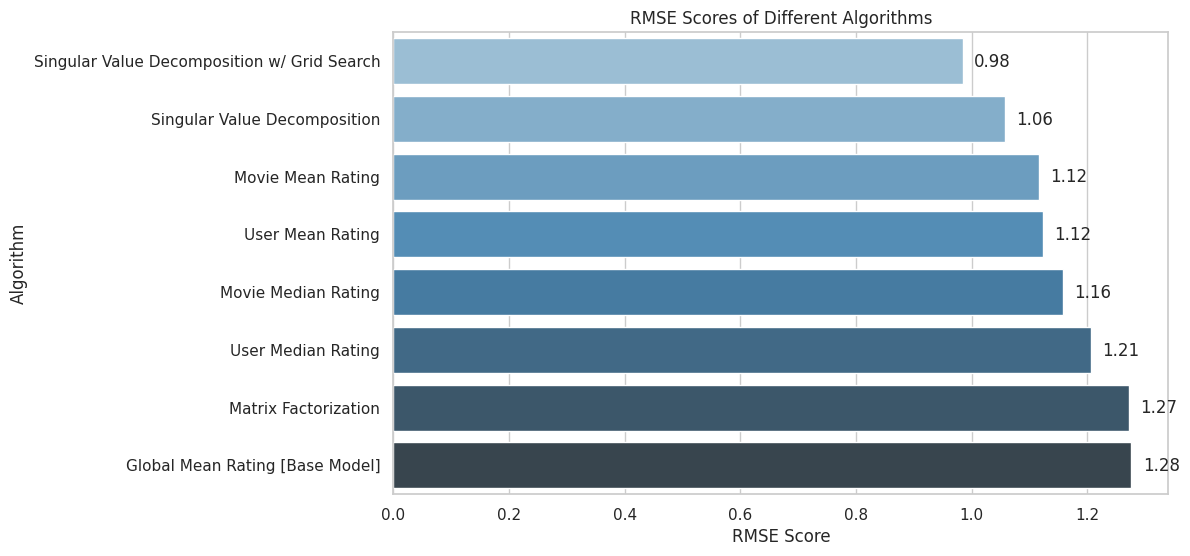

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Suppose you have the following RMSE scores and model names
algorithm_names = ['Global Mean Rating [Base Model]', 'User Mean Rating', 'User Median Rating', 'Movie Mean Rating', 'Movie Median Rating', 'Matrix Factorization', 'Singular Value Decomposition', 'Singular Value Decomposition w/ Grid Search']
rmse_values = [rmse_base, rmse_user_mean, rmse_user_median, rmse_movie_mean, rmse_movie_median, mf_test_rmse, svd_test_rmse, svd_optimal_rmse]  # replace with your actual RMSE scores

# Ensure both arrays have the same length
assert len(algorithm_names) == len(rmse_values), "Arrays must have the same length."

# Create a DataFrame from the model names and RMSE scores
rmse_data = pd.DataFrame({
    'Algorithm': algorithm_names,
    'RMSE': rmse_values
})

# Sort the DataFrame by RMSE
rmse_data = rmse_data.sort_values('RMSE')

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='RMSE', y='Algorithm', data=rmse_data, palette='Blues_d')

# Add the RMSE values on the plot
for i, v in enumerate(rmse_data['RMSE']):
    barplot.text(v + 0.02, i + 0.1, str(round(v, 2)))

plt.title('RMSE Scores of Different Algorithms')
plt.xlabel('RMSE Score')
plt.ylabel('Algorithm')
plt.show()

# [10] Extra Credit
### To analyze the data in further detail, we examine distribution of ratings for the "Cinema Connoisseur," "Selective Appraiser, and the "Avid User."


*   Cinema Connoisseur: 95th percentile in number of ratings given

*   Avid User: Between 5th percentile and 95th percentile in number of ratings given

*   Selective Appraiser: 5th percentile in number of ratings given


## Distribution of ratings for the "Cinema Connoisseur"




In [62]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np

# Identify Cinema Connoisseur as people with number of ratings > 0.95 (500 people)
num_rat = df.groupby('user_id').count()['rating']
quantile_95 = num_rat.quantile(0.95)
cinema_connoisseur_ind = num_rat[num_rat > quantile_95].index
cinema_connoisseur_ratings = df[df['user_id'].isin(cinema_connoisseur_ind)]['rating']

# Print info
print('Threshold of ratings to be a Cinema Connoisseur is: {}'.format(quantile_95))
print('Number of Cinema Connoisseurs are: {}'.format(len(cinema_connoisseur_ind)))

Threshold of ratings to be a Cinema Connoisseur is: 213.0
Number of Cinema Connoisseurs are: 23447


Text(0.5, 1.0, 'Mean of ratings for each movie')

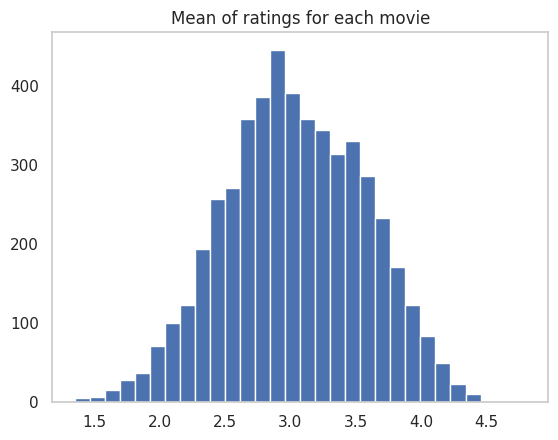

In [45]:
# Mean of ratings for each movie
means = df[df['user_id'].isin(cinema_connoisseur_ind)].groupby('movie_id')['rating'].mean()
plt.figure()
plt.hist(means, bins=30)
plt.grid()
plt.title('Mean of ratings for each movie')

Text(0.5, 1.0, 'Mean of ratings from each user')

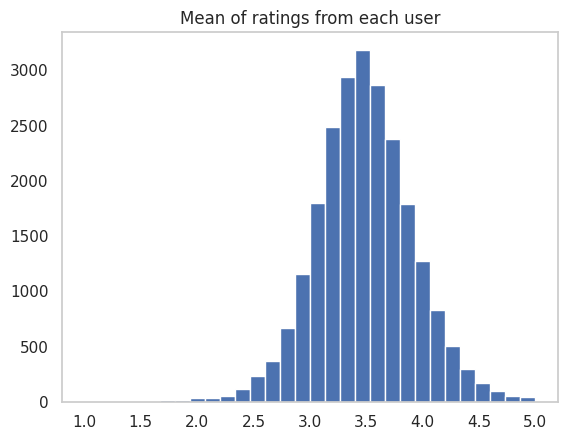

In [46]:
# Mean of ratings from each user
means = df[df['user_id'].isin(cinema_connoisseur_ind)].groupby('user_id')['rating'].mean()
plt.figure()
plt.hist(means, bins=30)
plt.grid()
plt.title('Mean of ratings from each user')

<ipython-input-47-bbb7da3e5fe1>:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_result = scipy.stats.mode(x)


Text(0.5, 1.0, 'Mode of ratings from each user')

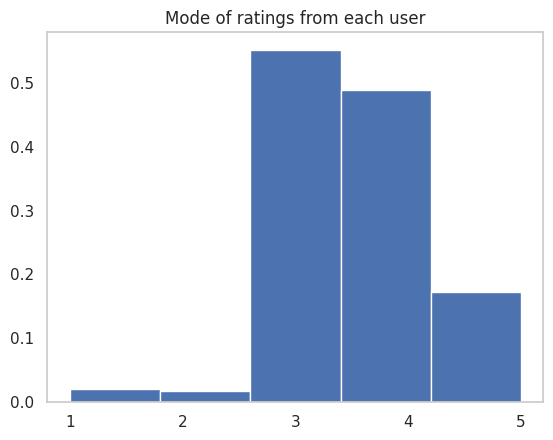

In [47]:
def custom_mode(x):
    mode_result = scipy.stats.mode(x)
    if mode_result.count[0] > 1:
        return mode_result.mode[0]
    else:
        return np.nan

# Mode of ratings from each user
mode = df[df['user_id'].isin(cinema_connoisseur_ind)].groupby('user_id')['rating'].agg(custom_mode)
plt.figure()
plt.hist(mode.dropna(), bins=5, density=True)
plt.xticks([1,2,3,4,5])
plt.grid()
plt.title('Mode of ratings from each user')

In [48]:
# Total ratings
print('Total ratings are: {}'.format(cinema_connoisseur_ratings.count()))

Total ratings are: 7618408


Text(0.5, 1.0, 'Distribution of ratings')

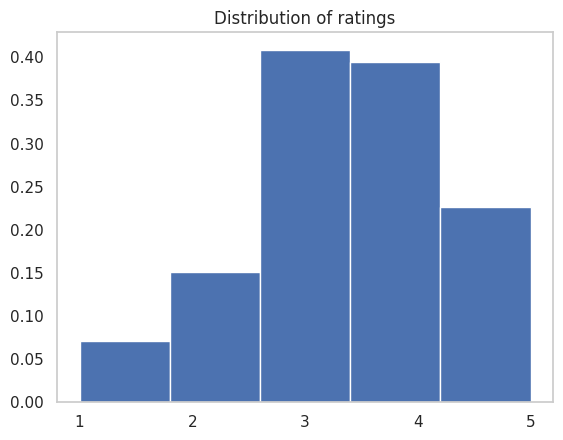

In [49]:
# Distribution of ratings
plt.figure()
plt.hist(cinema_connoisseur_ratings, bins=5, density=True)
plt.xticks([1,2,3,4,5])
plt.grid()
plt.title('Distribution of ratings')

## Distribution of ratings for the "Avid User"

In [63]:
# Identify Selective Appraiser as people with number of ratings < 0.05
quantile_05 = num_rat.quantile(0.05)
selective_appraiser_ind = num_rat[num_rat < quantile_05].index
selective_appraiser_ratings = df[df['user_id'].isin(selective_appraiser_ind)]['rating']

# Print info
print('Threshold of ratings to be a Selective Appraiser is: {}'.format(quantile_05))
print('Number of Selective Appraisers are: {}'.format(len(selective_appraiser_ind)))

Threshold of ratings to be a Selective Appraiser is: 2.0
Number of Selective Appraisers are: 12516


Text(0.5, 1.0, 'Mean of ratings for each movie')

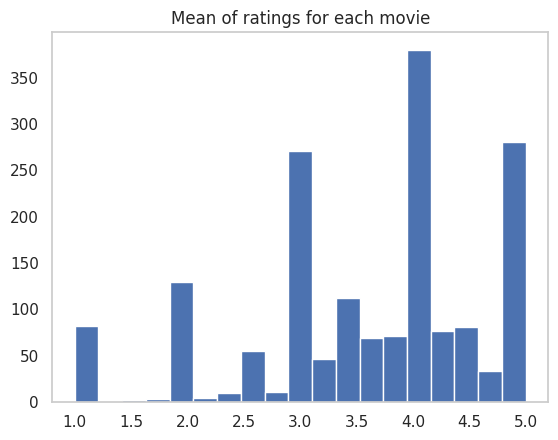

In [52]:
# Mean of ratings for each movie
means = df[df['user_id'].isin(selective_appraiser_ind)].groupby('movie_id')['rating'].mean()
plt.figure()
plt.hist(means.dropna(), bins='auto')
plt.grid()
plt.title('Mean of ratings for each movie')

Text(0.5, 1.0, 'Mean of ratings from each user')

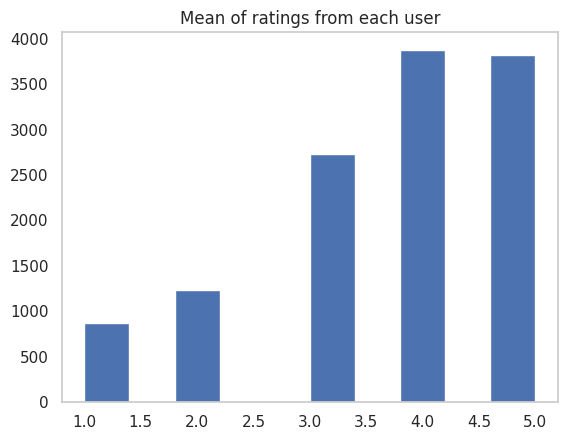

In [53]:
# Mean of ratings from each user
means = df[df['user_id'].isin(selective_appraiser_ind)].groupby('user_id')['rating'].mean()
plt.figure()
plt.hist(means)
plt.grid()
plt.title('Mean of ratings from each user')

Total ratings are: 12516


Text(0.5, 1.0, 'Distribution of ratings')

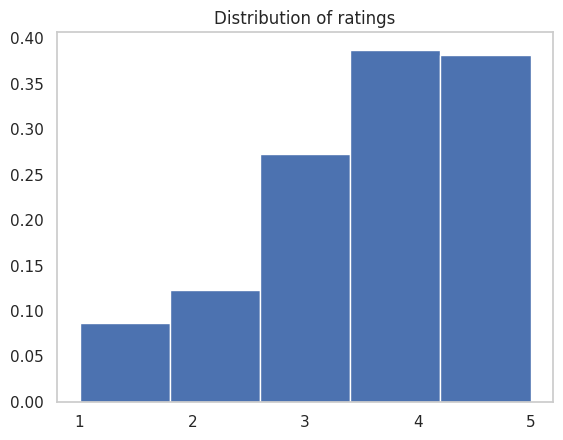

In [55]:
# Total ratings
print('Total ratings are: {}'.format(selective_appraiser_ratings.count()))

# Distribution of ratings
plt.figure()
plt.hist(selective_appraiser_ratings, bins=5, density=True)
plt.xticks([1,2,3,4,5])
plt.grid()
plt.title('Distribution of ratings')

## Distribution of ratings for the "Selective Appraiser"

In [56]:
# Identify Avid Users
avid_user_ind = num_rat[(num_rat < quantile_95) & (num_rat > quantile_05)].index
avid_user_ratings = df[df['user_id'].isin(avid_user_ind)]['rating']

# Print info
print('Threshold of ratings to be an Avid User is between {} and {}'.format(quantile_05, quantile_95))
print('Number of Avid Users are: {}'.format(len(avid_user_ind)))

Threshold of ratings to be an Avid User is between 2.0 and 213.0
Number of Avid Users are: 421635


Text(0.5, 1.0, 'Mean of ratings for each movie')

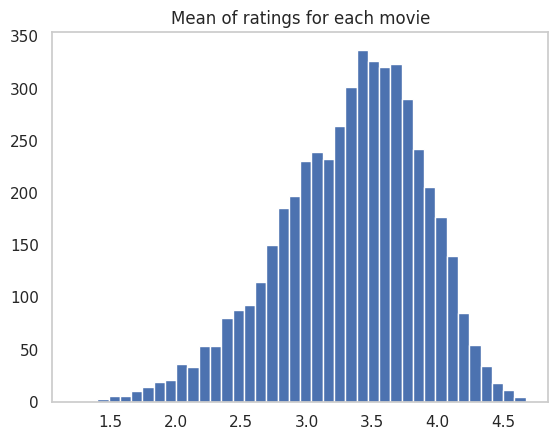

In [57]:
# Mean of ratings for each movie
means = df[df['user_id'].isin(avid_user_ind)].groupby('movie_id')['rating'].mean()
plt.figure()
plt.hist(means.dropna(), bins='auto')
plt.grid()
plt.title('Mean of ratings for each movie')

Text(0.5, 1.0, 'Mean of ratings from each user')

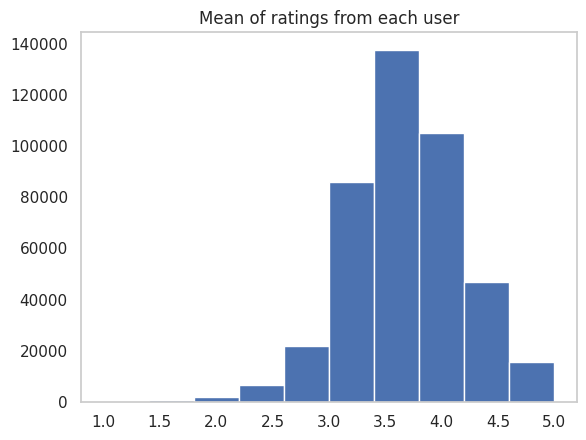

In [58]:
# Mean of ratings from each user
means = df[df['user_id'].isin(avid_user_ind)].groupby('user_id')['rating'].mean()
plt.figure()
plt.hist(means)
plt.grid()
plt.title('Mean of ratings from each user')

In [59]:
# Total ratings
print('Total ratings are: {}'.format(avid_user_ratings.count()))

Total ratings are: 19300461


Text(0.5, 1.0, 'Distribution of ratings')

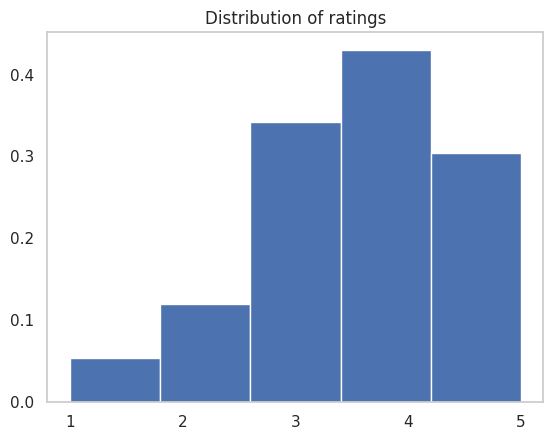

In [60]:
# Distribution of ratings
plt.figure()
plt.hist(avid_user_ratings, bins=5, density=True)
plt.xticks([1,2,3,4,5])
plt.grid()
plt.title('Distribution of ratings')

## Comparative Analysis of Segment-wise and Overall Distributions

--- Cinema Connoisseur ---
Mean rating: 3.45
Median rating: 3.00
Mode of ratings: 3.0
Total ratings: 7618408

--- Selective Appraiser ---
Mean rating: 3.68
Median rating: 4.00
Mode of ratings: 4.0
Total ratings: 12516

--- Avid User ---
Mean rating: 3.65
Median rating: 4.00
Mode of ratings: 4.0
Total ratings: 19300461

--- All Data ---
Mean rating: 3.59
Median rating: 4.00
Mode of ratings: 4.0
Total ratings: 27010225



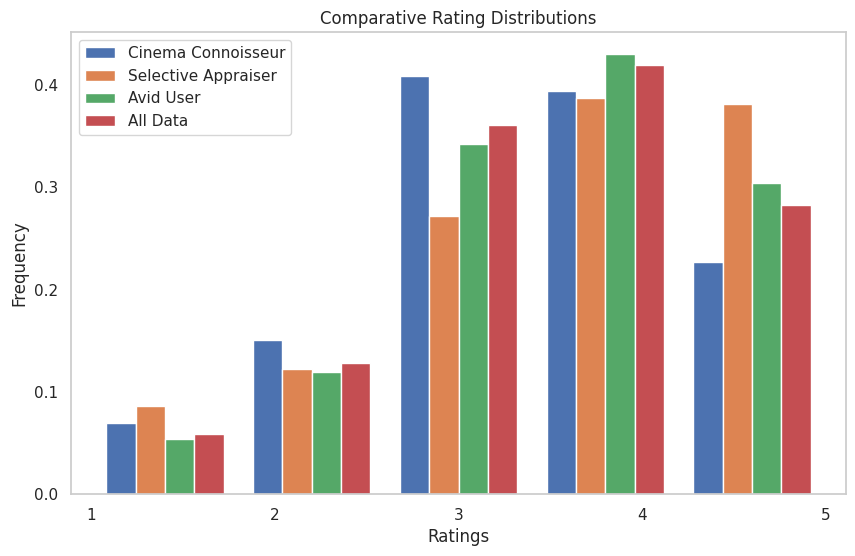

In [64]:
def compare_distributions(user_type, ratings):
    # Print information
    print(f'--- {user_type} ---')
    print(f'Mean rating: {ratings.mean():.2f}')
    print(f'Median rating: {ratings.median():.2f}')
    print(f'Mode of ratings: {ratings.mode()[0]}')
    print(f'Total ratings: {ratings.count()}\n')

# Compare distributions for each group
compare_distributions('Cinema Connoisseur', cinema_connoisseur_ratings)
compare_distributions('Selective Appraiser', selective_appraiser_ratings)
compare_distributions('Avid User', avid_user_ratings)

# Compare with all data
all_ratings = df['rating']
compare_distributions('All Data', all_ratings)

# Comparative visualization
plt.figure(figsize=(10, 6))
plt.hist([cinema_connoisseur_ratings, selective_appraiser_ratings, avid_user_ratings, all_ratings], 
         bins=5, density=True, histtype='bar', label=['Cinema Connoisseur', 'Selective Appraiser', 'Avid User', 'All Data'])
plt.xticks([1,2,3,4,5])
plt.grid()
plt.legend()
plt.title('Comparative Rating Distributions')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()